# TME 4 : Premiers filtres

> Consignes: le fichier TME4_Sujet.ipynb est à déposer sur le site Moodle de l'UE https://moodle-sciences.upmc.fr/moodle-2018/course/view.php?id=4650. Si vous êtes en binôme, renommez-le en TME4_nom1_nom2.ipynb.

In [4]:
# Chargement des modules et des données utiles.

from pylab import *

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.signal

image_cameraman = np.array(Image.open("images/cameraman.png"))
image_cameraman_bruit_impuls = np.array(Image.open("images/cameraman_salt_peper_3pct.png")) # L'image du cameraman avec un bruit poivre et sel (3% des pixels) 
image_cameraman_bruit_gauss = np.array(Image.open("images/cameraman_gauss_noise.png")) # L'image du cameraman avec un bruit gaussien centré (Variance 0.01)
image_rectangle = np.array(Image.open("images/rectangle.png"))
image_bateau = np.array(Image.open("images/boat.png"))
image_bateau_bruit_impuls = np.array(Image.open("images/boat_salt_peper_5pct.png")) # L'image du bateau avec un bruit poivre et sel (5% des pixels) 
image_bateau_bruit_gauss = np.array(Image.open("images/boat_gauss_noise.png")) # L'image du bateau avec un bruit gaussien centré (Variance 0.03)

def affichage_comparaison(image_non_bruite, image_debruitee, image_bruitee):
    s1 = plt.subplot(131)
    s1.set_title("Non bruitée")
    s1.imshow(image_non_bruite, cmap="gray",interpolation='nearest', aspect='equal')
    s2 = plt.subplot(132)
    s2.set_title("Débruitée")
    s2.imshow(image_debruitee, cmap="gray",interpolation='nearest', aspect='equal')
    s3 = plt.subplot(133)
    s3.set_title("Bruitée")
    s3.imshow(image_bruitee, cmap="gray",interpolation='nearest', aspect='equal')

    agrandissement = 3
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement, plSize[1]*agrandissement) )
    plt.show()

## Partie 1 : Convolution d'une image par un filtre

Dans cette partie, on écrira une fonction pour réaliser la convolution linéaire d'une image en niveau de gris par un filtre. Cette fonction sera utile dans la partie 2 pour le filtre moyenneur et pour les séances de TME suivantes.

### Exercice 1.1 : Padding d'une image

Un padding de l'image est la première étape nécessaire pour réaliser une convolution linéaire. Elle consiste à ajouter N lignes et colonnes de pixels de valeur 0 autour de l'image pour un filtre de taille 2N+1.

**A faire**: Complétez la fonction <tt>adding_image(image, N)</tt>.

Rappel: la taille d'une matrice <tt>M</tt> est donnée par <tt>M.shape</tt>

In [86]:
def padding_image(image, N):  
    """ Array*int -> Array 
    Réalise un zéro padding d'une image.
    """
    tab_image = np.array(image)
    h,w = tab_image.shape
    tab_new = np.zeros([h+2*N,w+2*N] ,dtype = np.int)
    
    tab_new[N:h+N,N:w+N] = tab_image
    
    return tab_new
    
    
    

Vous pouvez tester la fonction <tt>padding_image()</tt> avec la cellule suivante: vérifiez que la taille de l'image obtenue a les bonnes dimensions.

(266, 266)


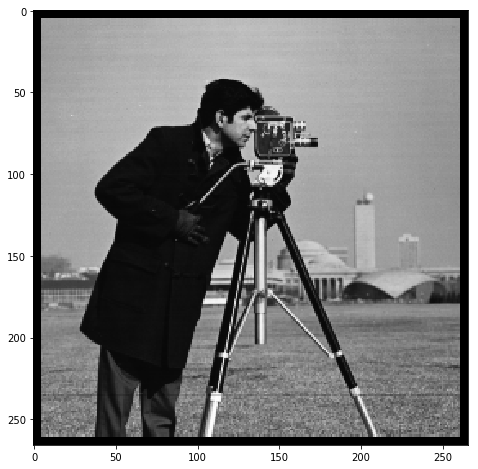

In [87]:
image_cameraman_pad = padding_image(image_cameraman,5)
print(image_cameraman_pad.shape)


plt.imshow(image_cameraman_pad, cmap="gray")
agrandissement = 2
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*agrandissement, plSize[1]*agrandissement) )
plt.show()

### Exercice 1.2 : Écriture de la fonction de convolution

Dans cette partie, on écrira une fonction <tt>convolution(image, filtre)</tt> qui calcule la convolution linéaire d'une image par un filtre. On utilisera la fonction <tt>padding_image()</tt> comme première étape.

On supposera que le filtre est un tableau de taille $(2N+1) \times (2N+1)$. 

PS: Il existe dans plusieurs modules Python des fonctions plus efficaces pour calculer un produit de convolution mais on s'interdira de les utiliser !

**À faire:** Complétez la fonction <tt>convolution(image, filtre)</tt>.

In [88]:
def convolution(image, filtre):
    """ Array*Array -> Array 
        retourne la convolution linéaire de image par filtre
    """
    #print(filtre)
    
    M,null = filtre.shape
    
    N = (int)((M-1)/2)
    tab_new = padding_image(image, N)
    
    h1,w1 = tab_new.shape
    
    
    
    h = h1-2*N
    w = w1-2*N
    
    
    filtre_inver = filtre.copy()
    
    for i in range(M):
        for j in range(M):
            filtre_inver[M-1-i,M-1-j] = filtre[i,j]
            
    #print(filtre_inver)
    
    tab_res = np.zeros([h, w],dtype = np.int)
    
    for i in range(N,h1-N):
        for j in range(N,w1-N):
            som = 0
            for cpth in range(M):
                for cptw in range(M):
                    som = som + (int)(filtre_inver[cpth,cptw]*tab_new[i-N+cpth,j-N+cptw])
                    
            tab_res[i-N,j-N] = som

            
    return tab_res
    


Vous pouvez contrôler le bon fonctionnement de votre fonction en vérifiant qu'elle donne le même résultat que la fonction <tt>convolve2d()</tt> du module Scipy. La norme de la différence doit être proche de 0.

In [89]:
filtre_test = np.array([[1,2,3],[4,5,6],[7,8,9]])
print("Norme de la différence: " + str(np.linalg.norm(convolution(image_cameraman, filtre_test) - scipy.signal.convolve2d(image_cameraman, filtre_test, mode = 'same'))))


Norme de la différence: 0.0


## Partie 2 : Réduction de bruit par filtrage linéaire: le filtre moyenneur

Dans cette partie, on réalisera le filtrage d'une image par des filtres moyenneurs de plusieurs tailles.

### Exercice 2.1 : Écriture de la fonction qui réalise le filtre moyenneur

**À faire:** Complétez la fonction <tt>filtre_moyenneur(image, N)</tt> où $N$ correspond à un filtre moyenneurde taille $N\times N$. Vous utiliserez la fonction <tt>convolution()</tt> écrite à l'exercice précédent.

In [91]:
def filtre_moyenneur(image, N):
    """ Array*int -> Array
        retourne l'image filtré par le filtre moyenneur de taille NxN
    """
    
    filtre = np.ones([N,N] ,dtype = np.int)
    
    #print(filtre)
    
    image_filtree = convolution(image, filtre)
    
    return image_filtree
    

### Exercice 2.2 : Étude du filtre moyenneur sur une image de synthèse

On appliquera ici des filtres moyenneurs de différentes tailles de fenêtre sur l'image image_rectangle.

On affichera les images avant et après filtrage. On tracera également la ligne du milieu de l'image.

**À faire**: Afficher les images et les lignes millieu avant et après filtrage pour des filtres de taille $3\times3$, $9\times9$ et $21\times21$

Que conclure sur l'effet du filtre sur les contours ?

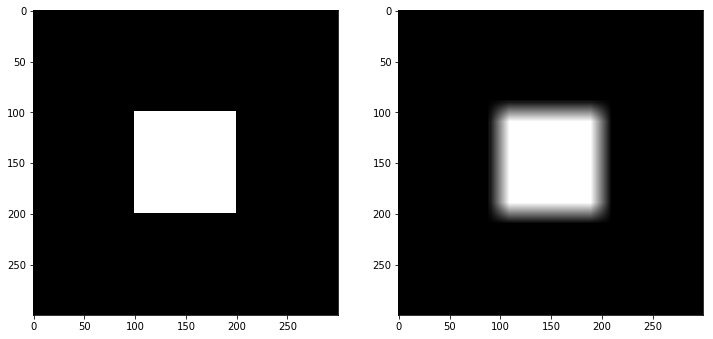

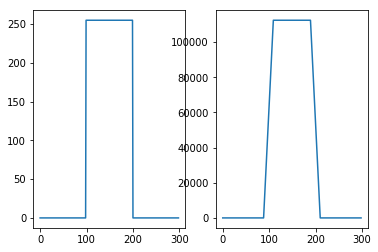

In [92]:
image_rectangle_filtre = filtre_moyenneur(image_rectangle, 21)

    
ligne_millieu = image_rectangle[0:299,150]
ligne_millieu_filtre = image_rectangle_filtre[0:299,150]

plt.subplot(121)
plt.imshow(image_rectangle, cmap="gray")
plt.subplot(122)
plt.imshow(image_rectangle_filtre, cmap="gray")

agrandissement = 2
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*agrandissement, plSize[1]*agrandissement) )
plt.show()

plt.subplot(121)
plt.plot(ligne_millieu)
plt.subplot(122)
plt.plot(ligne_millieu_filtre)



plt.show()

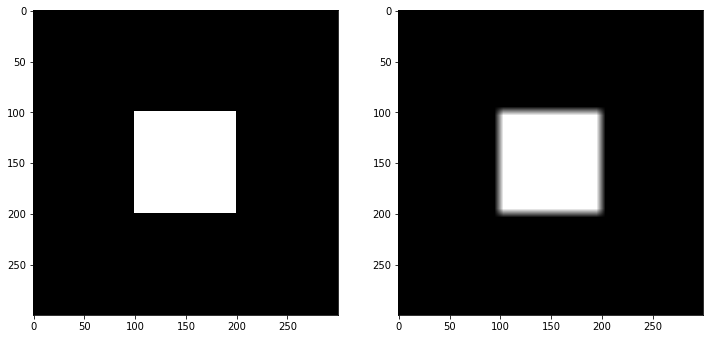

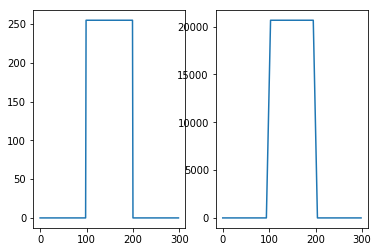

In [93]:
image_rectangle_filtre = filtre_moyenneur(image_rectangle, 9)

    
ligne_millieu = image_rectangle[0:299,150]
ligne_millieu_filtre = image_rectangle_filtre[0:299,150]

plt.subplot(121)
plt.imshow(image_rectangle, cmap="gray")
plt.subplot(122)
plt.imshow(image_rectangle_filtre, cmap="gray")

agrandissement = 2
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*agrandissement, plSize[1]*agrandissement) )
plt.show()

plt.subplot(121)
plt.plot(ligne_millieu)
plt.subplot(122)
plt.plot(ligne_millieu_filtre)



plt.show()

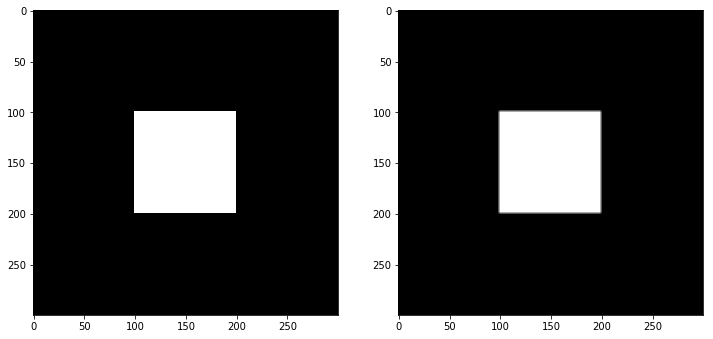

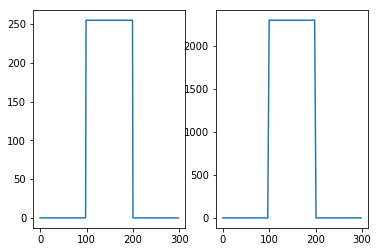

In [94]:
image_rectangle_filtre = filtre_moyenneur(image_rectangle, 3)

    
ligne_millieu = image_rectangle[0:299,150]
ligne_millieu_filtre = image_rectangle_filtre[0:299,150]

plt.subplot(121)
plt.imshow(image_rectangle, cmap="gray")
plt.subplot(122)
plt.imshow(image_rectangle_filtre, cmap="gray")

agrandissement = 2
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*agrandissement, plSize[1]*agrandissement) )
plt.show()

plt.subplot(121)
plt.plot(ligne_millieu)
plt.subplot(122)
plt.plot(ligne_millieu_filtre)



plt.show()

### Exercice 2.3 : Utilisation du filtre moyenneur pour le débruitage

Dans cette partie, on utilise le filtre moyenneur pour réduire le bruit de l'image <tt>image_cameraman_bruit_impuls</tt>.

**À faire:** Testez les filtres avec des fenêtres $3\times3$, $5\times5$ et $9\times9$. Que remarquez vous ?

Même question pour l'image <tt>image_cameraman_bruit_gauss</tt>.

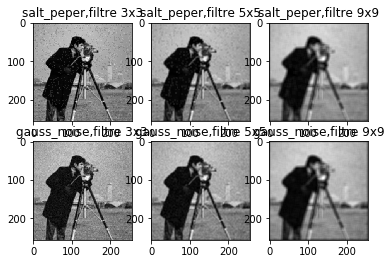

In [99]:
image1 = Image.open ('images/cameraman_salt_peper_3pct.png')
image2 = Image.open ('images/cameraman_gauss_noise.png')
res1 = filtre_moyenneur(image1, 3)
res2 = filtre_moyenneur(image1, 5)
res3 = filtre_moyenneur(image1, 9)
res4 = filtre_moyenneur(image2, 3)
res5 = filtre_moyenneur(image2, 5)
res6 = filtre_moyenneur(image2, 9)
subplot (2,3,1)
title('salt_peper,filtre 3x3')
imshow(res1, cmap='gray')
subplot (2,3,2)
title('salt_peper,filtre 5x5')
imshow(res2, cmap='gray')
subplot (2,3,3)
title('salt_peper,filtre 9x9')
imshow(res3, cmap='gray')
subplot (2,3,4)
title('gauss_noise,filtre 3x3')
imshow(res4, cmap='gray')
subplot (2,3,5)
title('gauss_noise,filtre 5x5')
imshow(res5, cmap='gray')
subplot (2,3,6)
title('gauss_noise,filtre 9x9')
imshow(res6, cmap='gray')

## Partie 3 : Réduction de bruit par filtrage non linéaire: le filtre médian

Dans cette partie, on cherchera à filtrer le bruit d'une image en utilisant un filtre médian. On rappelle que le filtre médian remplace chaque pixel par la valeur médiane dans son voisinage.

### Exercice 3.1: Implémentation du filtre médian

**À faire**: Implémentez le filtre médian pour une fenêtre de taille $N\times N$ variable. 

On utilisera un padding linéaire de l'image pour adapter les dimensions de l'image. Vous pouvez écrire une fonction utilisant un tri. Il est interdit d'utiliser des filtres médians déjà implémenté dans les modules Python.

On supposera que le voisinnage du pixel est un carré de coté impaire, centré en ce pixel.


In [96]:
def filtre_median(image, N):
        """ Array*int -> Array
            retourne l'image filtré par un médian de taille N
        """
        tab_image = np.array(image)
        h1,h2 = tab_image.shape
        
    
        M = (int)((N-1)/2)
        tab_new = padding_image(image, M)

        h,w = tab_new.shape
        
        tab_res = np.zeros([h1, h2],dtype = np.int)

        for i in range(M,h-M):
            for j in range(M,w-M):
                cpt = 0
                tab_sort = [0]*(N*N)
                for cpth in range(N):
                    for cptw in range(N):
                        tab_sort[cpt] = tab_new[i-M+cpth,j-M+cptw]
                        cpt = cpt + 1
                tab_sort.sort()
                tab_res[i-M,j-M] = tab_sort[(int)((N*N-1)/2)]
        
        return tab_res
    
    
   
    

Vérification: vous pouvez vérifier votre fonction en le comparant le résultat à celui obtenu avec le filtre médian de scipy. La norme de la différence doit être proche de 0.

In [97]:
np.linalg.norm(filtre_median(image_cameraman, 5) - scipy.ndimage.filters.median_filter(image_cameraman, size=(5, 5), mode='constant'))

0.0

### Exercice 3.2 : Utilisation du filtre médian pour le débruitage

Appliquez le filtre médian à l'image <tt>image_cameraman_bruit_gauss</tt> et à l'image <tt>image_cameraman_bruit_impuls</tt> en utilisant des fenetres de différentes tailles, par exemple $3\times3$, $9\times9$ et $21\times21$. Que remarquez vous ? Comparez le résultat avec celui obtenu avec le filtre moyenneur. Que concluez vous ?

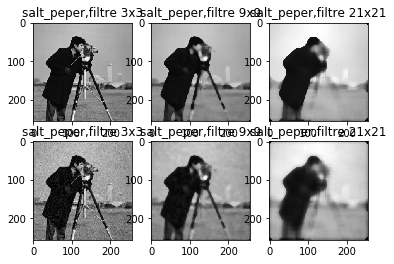

In [101]:
image1 = Image.open ('images/cameraman_salt_peper_3pct.png')
image2 = Image.open ('images/cameraman_gauss_noise.png')
res1 = filtre_median(image1, 3)
res2 = filtre_median(image1, 9)
res3 = filtre_median(image1, 21)
res4 = filtre_median(image2, 3)
res5 = filtre_median(image2, 9)
res6 = filtre_median(image2, 21)
subplot (2,3,1)
title('salt_peper,filtre 3x3')
imshow(res1, cmap='gray')
subplot (2,3,2)
title('salt_peper,filtre 9x9')
imshow(res2, cmap='gray')
subplot (2,3,3)
title('salt_peper,filtre 21x21')
imshow(res3, cmap='gray')
subplot (2,3,4)
title('salt_peper,filtre 3x3')
imshow(res4, cmap='gray')
subplot (2,3,5)
title('salt_peper,filtre 9x9')
imshow(res5, cmap='gray')
subplot (2,3,6)
title('salt_peper,filtre 21x21')
imshow(res6, cmap='gray')
